# Project: Investigate FBI Gun Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this project, I will clean and explore two datasets. The first dataset comes from the FBI's National Instant Criminal Background Check System. The NICS is used to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. The second dataset has been supplemented with state level data from census.gov.

The NICS data is found in one sheet of an .xlsx file. It contains the number of firearm checks by month, state, and type. The U.S. census data is found in a .csv file. It contains several variables at the state level. Most variables just have one data point per state (2016), but a few have data for more than one year.

By the end of this project, I will have addressed several questions: 
- How have guns sales changed over time?
- What are the top 5 state in guns per capita? And how has this changed over time?
- Which states have had the highest growth in guns sold per capita from 2010-2016?
- What census data is most associated with high gun per capita?

#### More information about the NICS data and calculating gun sales
The original PDF contains important notes and caveats. It's a good idea to read those first before diving into the data. Among the caveats is this important one:

> These statistics represent the number of firearm background checks initiated through the NICS They do not represent the number of firearms sold Based on varying state laws and purchase scenarios, a one-to-one correlation cannot be made between a firearm background check and a firearm sale

To convert background checks into gun sales, I relied on the methodology used in this [New York Times analysis](http://www.nytimes.com/interactive/2015/12/10/us/gun-sales-terrorism-obama-restrictions.html) which was suggested in the [2013 Small Arms Survey](http://www.smallarmssurvey.org/fileadmin/docs/F-Working-papers/SAS-WP14-US-Firearms-Industry.pdf) by Jurgen Brauer, a professor at Georgia Regents University:

> The magnitude of the demand for firearms in the United States can be approximated if one is willing to make two assumptions: firstly, that all permit checks are routine procedural checks by states against FBI records and are not associated with an intent to purchase a gun; and, secondly, that all in-store (retailer) checks by licensed firearms dealers against FBI records result in at least one firearms purchase. In terms of these assumptions, the percentage of in-store checks out of all NICS checks yields an approximated annual demand. 

> As approximations go, one may then add ‘handgun’ checks, plus ‘long gun’ checks, plus two ‘multiple’ checks (at least one handgun and one long gun), and augment the resulting number by a factor of 1.1, termed here the multiple gun sales factor (MGSF). 

Permit checks and other types of checks were omitted because each state maintains its own rules regarding the frequency, if any, with which its issued permits are checked against FBI records. The multiplier is an estimate based on Mr. Brauer's interviews with gun shop owners.

<a id='wrangling'></a>
## Data Wrangling

> In this section, the data is loaded, checked for cleanliness, and then trimmed and cleaned for analysis.

### General Properties

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

df_nics = pd.read_excel('gun_data.xlsx') #NICS data
df_census = pd.read_csv('U.S. Census Data.csv') #Census Data

In [272]:
#General properties of the raw NICS data
print("Number of Rows: ", df_nics.shape[0], "\nNumber of Columns: ", df_nics.shape[1],
      '\nNumber of duplicates: ', sum(df_nics.duplicated()), "\n")
display(df_nics.info())
df_nics.head()

Number of Rows:  12485 
Number of Columns:  27 
Number of duplicates:  0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
month                        12485 non-null object
state                        12485 non-null object
permit                       12461 non-null float64
permit_recheck               1100 non-null float64
handgun                      12465 non-null float64
long_gun                     12466 non-null float64
other                        5500 non-null float64
multiple                     12485 non-null int64
admin                        12462 non-null float64
prepawn_handgun              10542 non-null float64
prepawn_long_gun             10540 non-null float64
prepawn_other                5115 non-null float64
redemption_handgun           10545 non-null float64
redemption_long_gun          10544 non-null float64
redemption_other             5115 non-null float64
returned_handgun             2200 non-null f

None

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


##### Information about the NICS dataset
- Contains the number of firearm checks by month, state, and type.
- 12,485 rows, 27 columns
- Majority of columns contain null values.
- The columns without null values are month, state, multiple, totals
- 0 duplicate rows
- month and state columns are strings, mutiple and totals columns are integers, remaining columns are floats

Footnotes from the original PDF file:
>- other - Refers to frames, receivers and other firearms that are not either handguns or long guns (rifles or shotguns), such as firearms having a pistol grip that expel a shotgun shell
>- multiple - Multiple (multiple types of firearms selected)

Disclaimers:
>Some states may reflect lower than expected numbers for handgun checks based on varying state laws pertaining to handgun permits. Since the permit check is done in place of the NICS check in most of the affected states, the low handgun statistics are often balanced out by a higher number of handgun permit checks

In [273]:
#General properties of the raw Census Data
print("Number of Rows: ", df_census.shape[0], "\nNumber of Columns: ", df_census.shape[1],
      '\nNumber of duplicates: ', sum(df_census.duplicated()), "\n")
display(df_census.info())
df_census.head()

Number of Rows:  85 
Number of Columns:  52 
Number of duplicates:  3 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 52 columns):
Fact              80 non-null object
Fact Note         28 non-null object
Alabama           65 non-null object
Alaska            65 non-null object
Arizona           65 non-null object
Arkansas          65 non-null object
California        65 non-null object
Colorado          65 non-null object
Connecticut       65 non-null object
Delaware          65 non-null object
Florida           65 non-null object
Georgia           65 non-null object
Hawaii            65 non-null object
Idaho             65 non-null object
Illinois          65 non-null object
Indiana           65 non-null object
Iowa              65 non-null object
Kansas            65 non-null object
Kentucky          65 non-null object
Louisiana         65 non-null object
Maine             65 non-null object
Maryland          65 non-null object
Massachuset

None

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


##### Information about the Census dataset

- Contains several variables at the state level. Most variables just have one data point per state (2016), but a few have data for more than one year.
- 85 rows, 52 columns (one column for each state plus a Fact and Fact Note column)
- 3 duplicate rows - all columns contain null values
- All columns are strings, but values are floats, integers, or percentages
- The bottom row of the primary table of data in the file contains the FIPS code for each state

The dataset contains additional notes at the bottom:
> NOTE: FIPS Code values are enclosed in quotes to ensure leading zeros remain intact.	
	
>Value Notes	
1	Includes data not distributed by county.
	
>Fact Notes	
- (a)	Includes persons reporting only one race
- (b)	Hispanics may be of any race, so also are included in applicable race categories
- (c)	Economic Census - Puerto Rico data are not comparable to U.S. Economic Census data
	
>Value Flags	
- '-' : Either no or too few sample observations were available to compute an estimate, or a ratio of medians cannot be calculated because one or both of the median estimates falls in the lowest or upper interval of an open ended distribution.
- D	: Suppressed to avoid disclosure of confidential information
- F	: Fewer than 25 firms
- FN : Footnote on this item in place of data
- NA : Not available
- S	: Suppressed; does not meet publication standards
- X	: Not applicable
- Z	: Value greater than zero but less than half unit of measure shown!

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning (Replace this with more specific notes!)

##### NICS data
1. Remove state values that do not appear in the columns of the census data ('District of Columbia', 'Guam', 'Mariana Islands', 'Puerto Rico','Virgin Islands')
2. Check that the month and state columns did not have null values
3. Filled null values with 0.0
4. turned all float columns to integers, for consistency
5. Creates a year column
6. Remove unnecessary columns based - based on information from http://www.smallarmssurvey.org/fileadmin/docs/F-Working-papers/SAS-WP14-US-Firearms-Industry.pdf 

In [188]:
original = df_nics.shape[0]
#replace NAs with 0s
df_nics.fillna(0.0,inplace=True)

df_nics['handgun_totals'] = (df_nics.handgun + df_nics.prepawn_handgun + 
                             df_nics.redemption_handgun + df_nics.returned_handgun + df_nics.rentals_handgun + 
                             df_nics.private_sale_handgun + df_nics.return_to_seller_handgun)
df_nics['long_gun_totals'] = (df_nics.long_gun + df_nics.prepawn_long_gun + df_nics.redemption_long_gun + 
                              df_nics.returned_long_gun + df_nics.rentals_long_gun + df_nics.private_sale_long_gun + 
                              df_nics.return_to_seller_long_gun)

#remove columns that are not relevant
keep_cols = ['month', 'state', 'multiple', 'handgun_totals', 'long_gun_totals']
remove=[]
for col in list(df_nics.columns):
    if not col in keep_cols:
        remove.append(col)
df_nics.drop(remove, axis=1, inplace=True)

#new columns
df_nics['all_totals'] = df_nics.handgun_totals + df_nics.long_gun_totals + df_nics.multiple
df_nics['sales_estimate'] = 1.1 * (df_nics.handgun_totals + df_nics.long_gun_totals + df_nics.multiple * 2) #MGSF

#filter df_gun to only values that could be tied to the columns of the census data
state_list = list(df_census.columns[2:]) #list of states from census columns
remove_vals = df_nics.query('not state in {}'.format(state_list))
df_nics.drop(remove_vals.index, inplace=True)

#turn all columns to integers for consistency
for col in df_nics.columns[2:]:
    df_nics[col] = df_nics[col].astype(int)

#display(removed.state.unique())
print('Rows removed: ', str(original - df_nics.shape[0]))

df_nics.reset_index(inplace=True, drop=True)    
df_nics['year'] = df_nics['month'].apply(lambda x: x[:4])
df_nics = df_nics.query('not year in {}'.format(['1998', '2017']))

Rows removed:  1135


##### Census data
Steps:
1. Remove duplicates / null rows
2. Remove rows with all null values
3. Turn columns of each state into floats from strings
4. Creates a year column

In [189]:
#identifies and removes extra rows of information that include notes 
df_census_extra = df_census.iloc[64:,:] 
df_census.drop(df_census_extra.index,inplace=True)

census_t = df_census.transpose(copy=True)
census_t.head()
headers = census_t.iloc[0,:]
census_t.columns = headers

census_t.drop_duplicates(inplace=True)
census_t.drop(['Fact', 'Fact Note'],axis=0,inplace=True)
census_t.fillna("0",inplace=True)
census_t.head(1)

Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)","Persons 65 years and over, percent, April 1, 2010",...,"Total nonemployer establishments, 2015","All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010"
Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,...,"322,025","374,153","203,604","137,630","92,219","272,651","41,943","316,984",94.4,"50,645.33"


In [190]:
val_flags = ['-','D','F','FN','NA','S','X','Z'] #value flags found in bottom of data.
census_t.replace(to_replace=val_flags, value="0", inplace=True) #replace all value flags with 0

for col in census_t.columns:
    #first, if a value in a column has  a % sign, remove it and divide it by 100, else remove all commas and $
    census_t[col] = census_t[col].apply(lambda x: x.replace(',','').replace('$','').replace('%',''))
    census_t[col] = census_t[col].astype(float) #turn all state columns to floats


In [191]:
census_t['employment%_2015'] = census_t['Total employment, 2015'] / census_t['Population estimates, July 1, 2016,  (V2016)']

census_t['veterans%_2015'] = census_t['Veterans, 2011-2015'] / census_t['Population estimates, July 1, 2016,  (V2016)']

keep_dict = {'Population estimates, July 1, 2016,  (V2016)': 'population_2016',
             'Population estimates base, April 1, 2010,  (V2016)': 'population_2010',
             'Persons 65 years and over, percent,  July 1, 2016,  (V2016)': '65+%_2016',
             'High school graduate or higher, percent of persons age 25 years+, 2011-2015': 'highschool+%_2015',
             "Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015": 'bachelors+%_2015',
             'Median household income (in 2015 dollars), 2011-2015': 'median_income_2015',
             'Population per square mile, 2010': 'pop_per_sqmile_2010',
             'employment%_2015': 'employment%_2015',
             'veterans%_2015': 'veterans%_2015'}

remove_cols = []
for col in list(census_t.columns):
    if not col in list(keep_dict.keys()):
        remove_cols.append(col)
        
#census_t.drop(remove_cols, axis=1, inplace=True)

census_t.rename(columns=keep_dict, inplace=True)

#fact notes found at the bottom of the data
#notes = {'(a)':'Includes persons reporting only one race', 
         #'(b)':'Hispanics may be of any race, so also are included in applicable race categories', 
         #'(c)':'Economic Census - Puerto Rico data are not comparable to U.S. Economic Census data'}

#replace the keys from the notes dict with their values within the Fact Note column
#census_t['Fact Note'].replace(notes, inplace=True)



In [192]:
census_t.head()

Fact,population_2016,population_2010,"Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010",65+%_2016,"Persons 65 years and over, percent, April 1, 2010",...,"Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012",pop_per_sqmile_2010,"Land area in square miles, 2010",employment%_2015,veterans%_2015
Alabama,4863300.0,4780131.0,1.7,4779736.0,6.0,6.4,22.6,23.7,16.1,13.8,...,203604.0,137630.0,92219.0,272651.0,41943.0,316984.0,94.4,50645.33,0.336066,0.074676
Alaska,741894.0,710249.0,4.5,710231.0,7.3,7.6,25.2,26.4,10.4,7.7,...,35402.0,22141.0,13688.0,51147.0,7953.0,56091.0,1.2,570640.95,0.361236,0.093441
Arizona,6931071.0,6392301.0,8.4,6392017.0,6.3,7.1,23.5,25.5,16.9,13.8,...,245243.0,182425.0,135313.0,344981.0,46780.0,427582.0,56.3,113594.08,0.331144,0.072975
Arkansas,2988248.0,2916025.0,2.5,2915918.0,6.4,6.8,23.6,24.4,16.3,14.4,...,123158.0,75962.0,35982.0,189029.0,25915.0,192988.0,56.0,52035.48,0.335686,0.073941
California,39250017.0,37254522.0,5.4,37253956.0,6.3,6.8,23.2,25.0,13.6,11.4,...,1852580.0,1320085.0,1619857.0,1819107.0,252377.0,3176341.0,239.1,155779.22,0.364978,0.045284


In [262]:
df_nics.describe()

,multiple,handgun_totals,long_gun_totals,all_totals,sales_estimate
count,10800.000000,10800.000000,10800.000000,10800.000000,10800.000000
mean,293.625185,6715.870648,9212.993241,16222.489074,18167.286574
std,829.937163,9014.682909,9864.763272,17095.589100,19180.936879
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.000000,1433.750000,2991.250000,4945.750000,5527.750000
50%,150.000000,3805.500000,6548.000000,11358.500000,12699.000000
75%,325.000000,8297.000000,11798.500000,20919.250000,23514.750000
max,38907.000000,113976.000000,113874.000000,223851.000000,252058.000000


In [263]:
census_t.describe()

Fact,population_2016,population_2010,"Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010",65+%_2016,"Persons 65 years and over, percent, April 1, 2010",...,"Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012",pop_per_sqmile_2010,"Land area in square miles, 2010",employment%_2015,veterans%_2015
count,5.000000e+01,5.000000e+01,50.000000,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,...,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,50.00000,5.000000e+01,50.000000,50.000000,50.000000,50.000000
mean,6.448927e+06,6.163127e+06,3.120700,6.162876e+06,4.696780,5.021400,17.425780,18.338000,11.81044,9.989360,...,2.976230e+05,1.971777e+05,1.585531e+05,3.806367e+05,50502.72000,4.817082e+05,194.962000,70636.887800,0.384864,0.068846
std,7.271769e+06,6.848463e+06,3.366857,6.848235e+06,2.697349,2.902275,9.936137,10.431304,6.84738,5.814701,...,3.540115e+05,2.482425e+05,3.017390e+05,3.618627e+05,52073.87529,5.921109e+05,261.091465,85815.678218,0.041669,0.011423
min,5.855010e+05,5.637670e+05,-1.200000,5.636260e+05,0.052000,0.055000,0.197000,0.213000,0.14500,0.129000,...,3.003900e+04,1.934400e+04,2.354000e+03,3.851000e+04,6470.00000,5.135300e+04,1.200000,1033.810000,0.300951,0.041964
25%,1.850106e+06,1.833003e+06,0.069250,1.833004e+06,4.825000,5.125000,19.025000,20.700000,10.42500,8.025000,...,7.734775e+04,4.682475e+04,1.471450e+04,1.310602e+05,15796.50000,1.254088e+05,44.450000,36741.167500,0.360118,0.063418
50%,4.559320e+06,4.436412e+06,2.050000,4.436370e+06,6.000000,6.350000,22.250000,23.500000,15.00000,12.450000,...,1.951455e+05,1.274355e+05,6.306350e+04,2.769725e+05,38051.50000,2.959635e+05,98.750000,53891.280000,0.377150,0.069610
75%,7.198768e+06,6.680362e+06,5.075000,6.680312e+06,6.400000,6.800000,23.450000,24.550000,16.10000,13.800000,...,3.403212e+05,2.066418e+05,1.301590e+05,4.481730e+05,58253.25000,5.116312e+05,209.500000,81225.725000,0.409081,0.074939
max,3.925002e+07,3.725452e+07,10.800000,3.725396e+07,8.300000,9.500000,30.200000,31.500000,19.90000,17.300000,...,1.852580e+06,1.320085e+06,1.619857e+06,1.819107e+06,252377.00000,3.176341e+06,1195.500000,570640.950000,0.482739,0.093441


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.



### How have guns sales changed over time?

In [194]:
nics_year= df_nics.groupby(['year'], as_index=False).sum()

nics_month = df_nics.groupby(['month'], as_index=False).sum()

nics_state = df_nics.groupby(['state'], as_index=False, sort=False).sum().sort_values(by='sales_estimate', ascending=False)


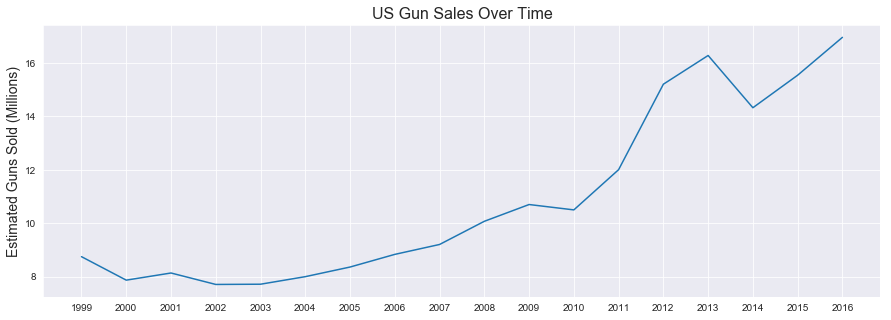

In [195]:
f, (ax1) = plt.subplots(1,1, figsize=(15,5))

ax1.plot(nics_year.year, nics_year.sales_estimate/1000000) #estimates in millions
ax1.set_ylabel('Estimated Guns Sold (Millions)', fontsize=14)
ax1.set_title('US Gun Sales Over Time', fontsize=16);


### What are the top 5 state in guns per capita? And how has this changed over time?

In [196]:
nics_year_state = df_nics.groupby(['year','state'], as_index=False, sort=False).sum()

In [197]:
def create_merge(year):
    
    merged = nics_year_state.query('year == "{}"'.format(year)).merge(census_t, how="inner", left_on='state', right_index=True).drop('year',axis=1)
    merged['sold_per_capita'] = merged.sales_estimate / merged['population_{}'.format(year)]
    merged.sort_values('sold_per_capita', ascending=False, inplace=True)
    merged.reset_index(drop=True, inplace=True)
    
    return merged

merged_2016 = create_merge('2016')
merged_2010 = create_merge('2010')


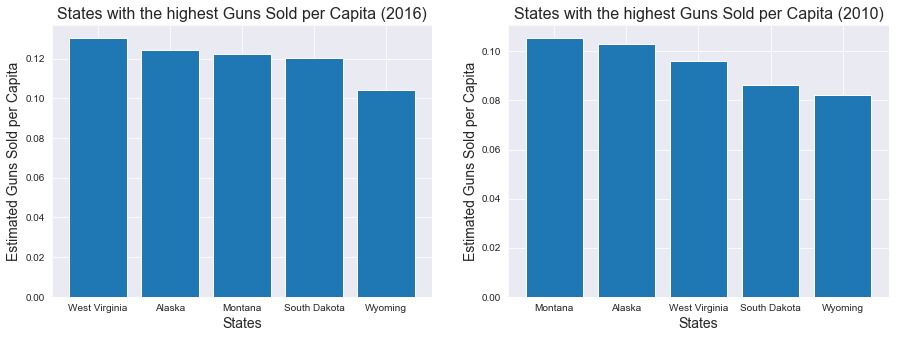

In [198]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.bar(merged_2016.state[:5], merged_2016.sold_per_capita[:5]) #top 5
ax1.set_xlabel('States', fontsize=14)
ax1.set_ylabel('Estimated Guns Sold per Capita', fontsize=14)
ax1.set_title('States with the highest Guns Sold per Capita (2016)', fontsize=16)

ax2.bar(merged_2010.state[:5], merged_2010.sold_per_capita[:5]) #top 5
ax2.set_xlabel('States', fontsize=14)
ax2.set_ylabel('Estimated Guns Sold per Capita', fontsize=14)
ax2.set_title('States with the highest Guns Sold per Capita (2010)', fontsize=16);



### Which states have had the highest growth in guns sold from 2010-2016, per capita?

In [199]:
merged_2016['sales_chg_10to16'] = (merged_2016.sales_estimate - merged_2010.sales_estimate) / merged_2016.population_2010

sorted_merge = merged_2016.sort_values(by='sales_chg_10to16', ascending=False)


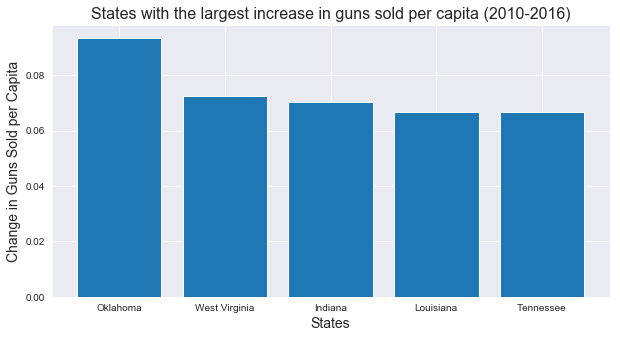

In [200]:
f, (ax1) = plt.subplots(1,1, figsize=(10,5))

ax1.bar(sorted_merge.state[:5], sorted_merge.sales_chg_10to16[:5]) #top 5
ax1.set_xlabel('States', fontsize=14)
ax1.set_ylabel('Change in Guns Sold per Capita', fontsize=14)
ax1.set_title('States with the largest increase in guns sold per capita (2010-2016)', fontsize=16);

### What census data is most associated with high gun per capita? 

In [259]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.

top_corr = merged_2016.corr(method='pearson')['sold_per_capita'].abs().sort_values(ascending=False)[1:5]
top_corr

veterans%_2015                                                     0.586827
pop_per_sqmile_2010                                                0.511081
Median gross rent, 2011-2015                                       0.501242
Median selected monthly owner costs -with a mortgage, 2011-2015    0.500696
Name: sold_per_capita, dtype: float64

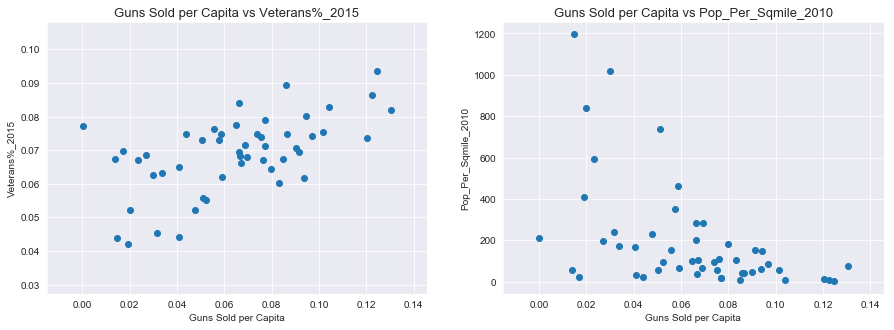

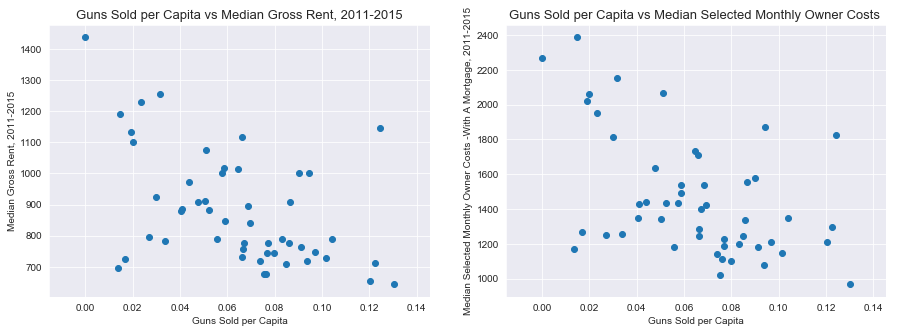

In [261]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.

def scatter_func(col1, col2):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.scatter(merged_2016.sold_per_capita, merged_2016[col1])
    ax1.set_title('Guns Sold per Capita vs {}'.format(col1[:36].title()), fontsize=13)
    ax1.set_xlabel('Guns Sold per Capita')
    ax1.set_ylabel(col1.title())
    
    
    ax2.scatter(merged_2016.sold_per_capita, merged_2016[col2])
    ax2.set_title('Guns Sold per Capita vs {}'.format(col2[:36].title()), fontsize=13)
    ax2.set_xlabel('Guns Sold per Capita')
    ax2.set_ylabel(col2.title());
    
    
#f, (ax1, ax2, ax3, ax4) = plt.subplots(2,2)
i = 0
while i < len(top_corr.index):
    scatter_func(top_corr.index[i], top_corr.index[i+1])
    i+=2

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!